## Spark NLP Annotations

In [1]:
data_file = '/home/user/elicon/data/Test_Data/Nepal_Quake/json/batch1/'
df = spark.read.option("header","true").csv(data_file)

In [2]:
#data = spark. \
#        read. \
#        parquet("../sentiment.parquet"). \
#        limit(1000)
df.cache()
df.count()
df.show()

+----------------------------------------------+-----------------------+-----------------------------+-------------------------------------------------------------------------------------------------------------------------+--------------------+--------------------------+--------------------+------------------------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------------------------------+--------------------------------------------+------------------------------------+--------------------+--------------------+-------------------------------------------------------------------------------------------------+------------------------------+----------------------------------+----------------------------+--------------------------------+--------------------------------+----------------------+--------------------+----------------------+----------------------------+--------------------------+-----------

In [3]:
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *
from pyspark.ml import Pipeline
### Define the dataframe                                                               
document_assembler = DocumentAssembler() \
            .setInputCol("tweet")
assembled = document_assembler.transform(df)    

In [4]:
tokenizer = Tokenizer() \
  .setInputCols(["document"]) \
  .setOutputCol("token") \
  #.addInfixPattern("(\p{L}+)(n't\b)")
tokenized = tokenizer.transform(assembled)    

In [ ]:
extractor = EntityExtractor()\
  .setEntities("file://" + os.getcwd() + "/entities.txt")\
  .setInputCols(["token"])\
  .setOutputCol("entities")

In [7]:
stemmer = Stemmer() \
  .setInputCols(["token"]) \
  .setOutputCol("stem")
stemmed = stemmer.transform(tokenized)

In [9]:
### Spell Checker
spell_checker = NorvigSweetingApproach() \
            .setInputCols(["stem"]) \
            .setOutputCol("spell")
checked = spell_checker.fit(stemmed).transform(stemmed)        

In [10]:
token_assembler = TokenAssembler() \
.setInputCols(["spell"]) \
.setOutputCol("assembled")

In [11]:
finisher = Finisher() \
    .setInputCols(["assembled"]) \
    .setIncludeKeys(True) \
    .setCleanAnnotations(False)

In [12]:
pipeline = Pipeline(stages=[
    document_assembler,
    tokenizer,
    stemmer,
    spell_checker,
    token_assembler,
    finisher
])

In [13]:
spelled_data = pipeline.fit(df).transform(df)
spelled_data.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|               tweet|            document|               token|                stem|               spell|           assembled|  finished_assembled|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|RT @bgittleson: T...|[[document,0,86,R...|[[token,0,1,RT,Ma...|[[token,0,1,rt,Ma...|[[token,0,1,rt,Ma...|[[document,21,25,...|result->photo@res...|
|                Okay|[[document,0,3,Ok...|[[token,0,3,Okay,...|[[token,0,3,okai,...|[[token,0,3,okai,...|[[document,0,3,ok...|        result->okai|
|Typical. I go to ...|[[document,0,75,T...|[[token,0,7,Typic...|[[token,0,7,typic...|[[token,0,7,typic...|[[document,0,7,ty...|result->typical.@...|
|HOT HT to explore...|[[document,0,107,...|[[token,0,2,HOT,M...|[[token,0,2,hot,M...|[[token,0,2,hot,M...|

In [15]:
spelled_data.select('assembled').show(2, False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|assembled                                                                                                                                                                                                                                                                                                                                                                         |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Simple feature training

In [2]:
# Load the Dataset 
from pyspark.sql import DataFrame
#data_file = '/home/user/elicon/data/Test_Data/California_Quake/json/california_earthquake_rawTweets.csv'
#data_file = '/home/user/elicon/data/Test_Data/California_Quake/unlabelled/retweeted/processed/napa_fin.csv'
data_file = '/home/user/elicon/data/Test_Data/California_Quake/datasets/california_test.csv'
df = spark.read.option("header","true").csv(data_file)
df = df.select(df.tweet_text,df.label.cast("double").alias("label"))
df = df.dropna()
df.createOrReplaceTempView("tweets")
tweet_label = spark.sql("SELECT tweet_text, label FROM tweets")

tweet_text_only = spark.sql("SELECT tweet_text FROM tweets")

In [3]:
# Tokenise tweets
from pyspark.ml.feature import Tokenizer
#from pyspark.sql.functions import col, udf
#from pyspark.sql.types import IntegerType

tokenizer = Tokenizer(inputCol="tweet_text", outputCol="words")
#countTokens = udf(lambda words: len(words), IntegerType())
#tokenized = tokenizer.transform(tweet_label)
#tokenized = tokenized.withColumn("tokens", countTokens(col("words")))

In [4]:
from pyspark.ml.feature import StopWordsRemover
# stop words
add_stopwords = ["amp","rt","ca","pg","ga","cb","ap","sce","st"] # standard stop words
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)

In [5]:
# 3-Gram for context feature
from pyspark.ml.feature import NGram

ngram = NGram(n=3, inputCol="filtered", outputCol="ngrams")
#ngrams = ngram.transform(tokenized)

## Use HashingTF Feature Extraction

In [28]:
# Hashing TF feature extraction
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.linalg import Vector as MLVector, Vectors as MLVectors
from pyspark.mllib.linalg import Vector as MLLibVector, Vectors as MLLibVectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.feature import VectorAssembler

hashingTF = HashingTF(inputCol="ngrams", outputCol="rawFeatures", numFeatures=50000)
#featurizedData = hashingTF.transform(ngrams)
# alternatively, CountVectorizer can also be used to get term frequency vectors
idf = IDF(inputCol="rawFeatures", outputCol="features")
#idfModel = idf.fit(featurizedData)
#tfidfData = idfModel.transform(featurizedData)
#assembler = VectorAssembler(
#    inputCols=["features", "tokens"],
#    outputCol="union_features")
#assembledData = assembler.transform(tfidfData)
#pairs = assembledData.select("label","features").rdd
#pairs = tfidfData.select("label","features").rdd
#data = pairs.map(lambda x: LabeledPoint(x[0], as_mllib(x[1])))


In [15]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [7]:
# Convert to labeled vectors
from pyspark.ml import linalg as ml_linalg

def as_mllib(v):
    if isinstance(v, ml_linalg.SparseVector):
        return MLLibVectors.sparse(v.size, v.indices, v.values)
    elif isinstance(v, ml_linalg.DenseVector):
        return MLLibVectors.dense(v.toArray())
    else:
        raise TypeError("Unsupported type: {0}".format(type(v)))        

## Word2Vec Feature Extraction

In [7]:
from pyspark.ml.feature import Word2Vec
# Learn a mapping from words to Vectors.
word2Vec = Word2Vec(vectorSize=2000, minCount=5, inputCol="ngrams", outputCol="features")

## Pipeline

In [29]:
from pyspark.ml import Pipeline
#pipeline = Pipeline(stages=[tokenizer,stopwordsRemover, ngram, word2Vec])# Fit the pipeline to training documents.
pipeline = Pipeline(stages=[tokenizer, stopwordsRemover, ngram, hashingTF, idf])# Fit the pipeline to training documents.

In [30]:
pipelineFit = pipeline.fit(tweet_label)
dataset = pipelineFit.transform(tweet_label)
### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)

In [11]:
tokenized = tokenizer.transform(tweet_label)
stopword = stopwordsRemover.transform(tokenized)
ngrams = ngram.transform(stopword)
featurizedData = hashingTF.transform(ngrams)
idfModel = idf.fit(featurizedData)
tfidfData = idfModel.transform(featurizedData)
pairs = tfidfData.select("label","features").rdd
data = pairs.map(lambda x: LabeledPoint(x[0], as_mllib(x[1])))

In [12]:
splits = data.randomSplit([0.6, 0.4], 1234)
mllib_trainingData = splits[0]
mllib_testData = splits[1]

## Logistic Regression

In [31]:
from pyspark.ml.classification import LogisticRegression
# Build the model
lr = LogisticRegression(maxIter=50, regParam=0.3, elasticNetParam=0)

# Train model with Training Data
lrModel = lr.fit(trainingData)

In [32]:
# Run Results on Training Data
trainingSummary = lrModel.summary
print("Training: Area Under ROC: " + str(trainingSummary.areaUnderROC))

Training: Area Under ROC: 1.0


In [33]:
# Predict on Test Data
predictions = lrModel.transform(testData)
# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.548237476809


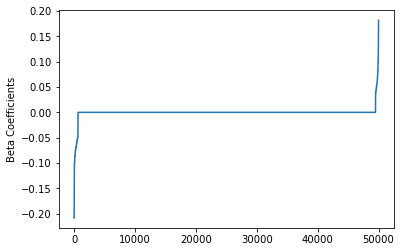

In [34]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrModel.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

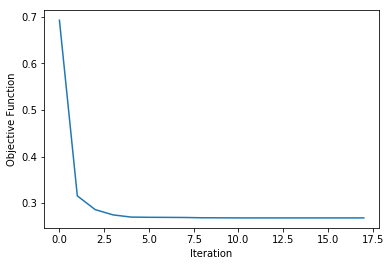

In [35]:
# Extract the summary from the returned LogisticRegressionModel instance trained
trainingSummary = lrModel.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
plt.plot(objectiveHistory)
plt.ylabel('Objective Function')
plt.xlabel('Iteration')
plt.show()

areaUnderROC: 1.0


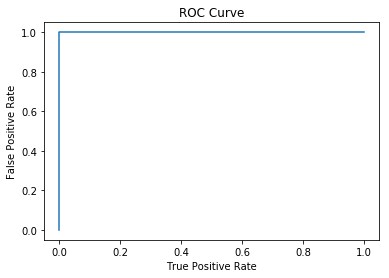

In [36]:
# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

#trainingSummary.roc.show(n=10, truncate=15)
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

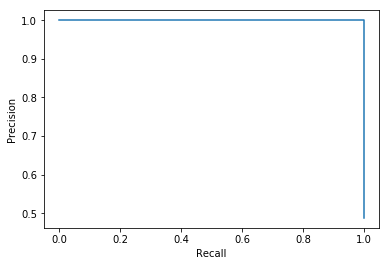

In [37]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

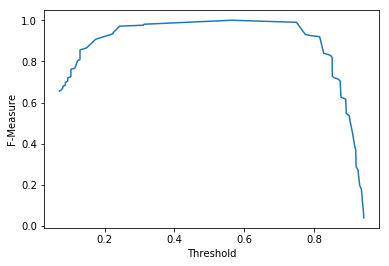

In [38]:
# Set the model threshold to maximize F-Measure
#trainingSummary.fMeasureByThreshold.show(n=10, truncate = 15)
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
#            .addGrid(model.maxIter, [10, 20, 50]) #Number of iterations
#            .addGrid(idf.numFeatures, [10, 100, 1000]) # Number of features
             .build())

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)

# Run cross validations
cvModel = cv.fit(trainingData)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

# Use test set here so we can measure the accuracy of our model on new data
predictions = cvModel.transform(testData)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

## Random Forest

In [39]:
from pyspark.ml.classification import RandomForestClassifier

# Create an initial RandomForest model.
rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)

# Train model with Training Data
rfModel = rf.fit(trainingData)

In [40]:
# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.548237476809


In [27]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [50, 100, 200]) # number of trees
             .addGrid(rf.maxDepth, [3, 4, 5]) # maximum depth
#            .addGrid(rf.maxBins, [24, 32, 40]) #Number of bins
             .build())

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=rf, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)

# Run cross validations
cvModel = cv.fit(trainingData)

# Use test set here so we can measure the accuracy of our model on new data
predictions = cvModel.transform(testData)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.522727272727


## Gradient Boosting Machines

In [43]:
from pyspark.ml.classification import GBTClassifier

# Train a GBT model.
gbt = GBTClassifier(labelCol="label", \
                    featuresCol="features", \
                    maxIter=10 \
                    )

# Train model.  This also runs the indexers.
model = gbt.fit(trainingData)

KeyboardInterrupt: 

In [ ]:
# Make predictions.
predictions = model.transform(testData)

# Select (prediction, true label) and compute test error
evaluator = BinaryClassificationEvaluator(labelCol="label", \
                                          rawPredictionCol="prediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

## Naive Bayes

In [44]:
from pyspark.ml.classification import NaiveBayes

# create the trainer and set its parameters
nb = NaiveBayes(smoothing=1, modelType="multinomial")

# train the model
model = nb.fit(trainingData)

# select example rows to display.
predictions = model.transform(testData)

# compute accuracy on the test set
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test: Area Under ROC: 0.539888682746


## SVM

In [36]:
# ## Linear SVM
from pyspark.mllib.classification import SVMWithSGD, SVMModel 
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Build the model
model = SVMWithSGD.train(mllib_trainingData, iterations=100)

# Evaluating the model on training data
labelsAndPreds = mllib_trainingData.map(lambda p: (p.label, model.predict(p.features)))
trainErr = labelsAndPreds.filter(lambda (v, p): v != p).count() / float(mllib_trainingData.count())
print("Training Error = " + str(trainErr))

Training Error = 0.0923802553468


## Model Evaluation

In [38]:
scoreAndLabels = mllib_testData.map(lambda p: (p.label, model.predict(p.features)))
srt = scoreAndLabels.map(lambda xs: [float(x) for x in xs])
nest = srt.map(lambda l : tuple(l) )
metrics = BinaryClassificationMetrics(nest)
au_ROC = metrics.areaUnderROC
au_PR = metrics.areaUnderPR

In [39]:
au_PR

0.7278760022933515

## Save the trained model

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[tokenizer, ngram, hashingTF, idf])
pipeline.save("target/tmp/HashingTF_Binary_pipeline")

In [ ]:
pipeModel = pipeline.fit(tweet_label)
pipeModel.save("target/tmp/HashingTF_Binary_model")

In [ ]:
model.save(sc, "target/tmp/SVMWithSGD_Binary_model")

## Multi-feature training

In [ ]:
import re
def search(text, search_word):
    word = r"\W*([\w]+)"
    groups = re.search(r"{}\W*{}{}".format(word, search_word, word), text).groups()
    return list(groups[:1]),list(groups[1:])   

In [ ]:
t = "fire erupt quak rock california wine countri"
tuple1 = search(t, "quak")
contents = list(tuple1)
content = [item for sub in contents for item in sub]

In [ ]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(
    inputCols=["label", "tokens"],
    outputCol="union_features")
assembledData = assembler.transform(ngrams)

In [ ]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="ngrams", outputCol="ngrams_numeric").fit(ngrams)
indexed_df = indexer.transform(ngrams)
#indexed_df.drop("bar").show()